# Convolutional networks
This file shows how to programm and setup a convolutional neural network using Tensorflow.
Steps to do:
	- download and import data
    - preprocess data (structure data into training, validation, test set etc)
    - create mini-batches of data for training
    - setup or import a neural network model (tf.Graph)
    - define loss function
    - train neural network
    - evaluate neural network
    - provide an inference function for predicting labels of test data set (unknown data)
    - visualize neural network data with tensorflow and here in jupyter notebook

## Import and definition of prediction function:

In [1]:
"""
Predict albedo and shading layer of an input image.
"""

import os
import sys
sys.path.append('./util')
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import input_queues as iq
import plot_helpers as plt_help
import cnn_helpers as chlp


__author__ = "Udo Dehm"
__copyright__ = "Copyright 2017"
__credits__ = ["Udo Dehm"]
__license__ = ""
__version__ = "0.1"
__maintainer__ = "Udo Dehm"
__email__ = "udo.dehm@mailbox.org"
__status__ = "Development"

__all__ = ['predict']

# make only 'gpu:0' visible, so that only one gpu is used not both, see also
# https://github.com/tensorflow/tensorflow/issues/5066
# https://github.com/tensorflow/tensorflow/issues/3644#issuecomment-237631171
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

data_dir = '/media/sdb/udo/data/'

In [2]:
def predict(image, path_inference_graph, checkpoint_path,
            nodes_name_dict, plot_inference_graph=False):
    """
    :param image:
    :type image:
    :param path_inference_graph: path to inference graph (graph without 
        'training' ops)
    :type path_inference_graph: str
    :param checkpoint_path: path to model parameters (checkpoint files
        e.g. 'logs/2/tfmodel-5')
    :type checkpoint_path: str
    :param nodes_name_dict: dictionary that contains name of input, albedo and 
        shading output in form {'input': '', 
                                'output_albedo': '',
                                'output_shading': ''}
    :type nodes_name_dict: dict
    :param plot_inference_graph: flag, True if inference graph should be 
        plotted (default: False).
    :type plot_inference_graph: boolean

    :return: prediction albedo layer, prediction shading layer
    """
    # clear default graph:
    tf.reset_default_graph()
     
    # import meta (inference) graph:
    meta_graph = tf.train.import_meta_graph(path_inference_graph,
                                            clear_devices=True)
    # save default graph in variable:
    graph = tf.get_default_graph()
    if plot_inference_graph:
        # plot imported inference graph:
        plt_help.show_graph(graph.as_graph_def())

    ############################################################################
    ############################################################################
    # defining input/output nodes:

    # lets get the input
    x = graph.get_tensor_by_name(name=nodes_name_dict['input'])

    # bool variable that indicates if we are in training mode (training=True) or
    # valid/test mode (training=False) this indicator is important if dropout 
    # or/and batch normalization is used.
    try:
        # try importing training node (is needed for models that use batch 
        # normalization etc.)
        try:
            training = graph.get_tensor_by_name(name='is_training_1:0')
        except KeyError:
            training = graph.get_tensor_by_name(name='is_training:0')
        print('INFO: Was able to catch is_training node.')
        print(training)
    except KeyError:
        # elsewise just define a placeholder wich is used as dummy variable
        # and won't be used later:
        training = tf.placeholder(dtype=tf.bool, name='is_training')

    # get graph output nodes:
    y_albedo_pred = graph.get_tensor_by_name(name=nodes_name_dict['output_albedo'])
    y_shading_pred = graph.get_tensor_by_name(name=nodes_name_dict['output_shading'])

    # y_albedo_pred = tf.clip_by_value(t=y_albedo, clip_value_min=0, 
    #                                  clip_value_max=1, 
    #                                  name='0_1_clipping_albedo')
    # y_shading_pred = tf.clip_by_value(t=y_shading, clip_value_min=0,
    #                                   clip_value_max=1, 
    #                                   name='0_1_clipping_shading')

    ############################################################################
    ############################################################################
    # making prediction:
    config = tf.ConfigProto(device_count = {'GPU': 1},
                            intra_op_parallelism_threads=3)
    with tf.Session(config=config) as sess: 
        # Restore variables from disk.
        meta_graph.restore(sess, checkpoint_path)
        # make predictions:
        feed_dict = {x: image, 
                     training: False}

        pred_alb, pred_shad = sess.run([y_albedo_pred, y_shading_pred],
                                       feed_dict=feed_dict)
    
    return pred_alb, pred_shad

## Predictions for Sintel dataset:
### Load Sintel dataset:

In [3]:
def load_sintel_dataset(file, output_shape=[436, 1024, 3]):
    df_sintel = pd.read_csv(file, sep=',', header=None,
                            names=['img', 'alb', 'shad', 'invalid'])
    # compolete image paths:
    df_sintel = '/'.join(file.split('/')[:-1]) + '/' + df_sintel
    # import images:
    return iq.next_batch_sintel(deq=df_sintel,
                                output_shape=output_shape,
                                is_scale=False,
                                is_flip=False,
                                is_rotated=False,
                                norm=True)

In [4]:
# testing data set:
file_sintel_train = data_dir + 'data_sintel_shading_train.csv'
file_sintel_valid = data_dir + 'data_sintel_shading_valid.csv'
file_sintel_test = data_dir + 'data_sintel_shading_test.csv'
#output_shape = [320, 320, 3]
# output_shape = [320, 960, 3]
output_shape = [416, 1024, 3]
# output_shape = [436, 1024, 3]

In [5]:
# img_sintel_train_b, alb_sintel_train_b, shad_sintel_train_b, inv_sintel_train_b = load_sintel_dataset(file=file_sintel_train,
#                                                                                                       output_shape=output_shape)
img_sintel_valid_b, alb_sintel_valid_b, shad_sintel_valid_b, inv_sintel_valid_b = load_sintel_dataset(file=file_sintel_valid,
                                                                                                      output_shape=output_shape)
img_sintel_test_b, alb_sintel_test_b, shad_sintel_test_b, inv_sintel_test_b = load_sintel_dataset(file=file_sintel_test,
                                                                                                  output_shape=output_shape)

/home/udo/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


(-0.5, 1023.5, 415.5, -0.5)

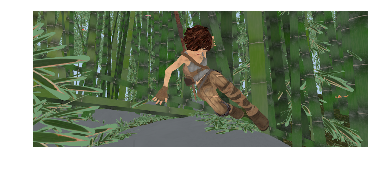

In [6]:
plt.imshow(alb_sintel_test_b[3])
plt.axis('off')

### Perform predictions on sintel dataset:

In [7]:
# sintel_slim_resnet_v1_50_narihira2015_reduced/...:
nodes_name_dict = {'input': 'input:0',
                   'output_albedo': 'decoder/deconv7_albedo/BiasAdd:0',
                   'output_shading': 'decoder/deconv7_shading/BiasAdd:0'}
# .../norm_l1:
params = {'path_inference_graph': 'models/slim/graphs/resnet_v1_50_narihira2015_reduced/tfmodel_inference.meta',
          'checkpoint_path': '/media/sdb/udo/logs/sintel/slim_resnet_v1_50_narihira2015_reduced/1/tfmodel-4300',
          'nodes_name_dict': nodes_name_dict,
          'plot_inference_graph': False}

In [8]:
# pred_alb_train, pred_shad_train = predict(image=img_sintel_train_b, **params)
pred_alb_valid, pred_shad_valid = predict(image=img_sintel_valid_b, **params)
pred_alb_test, pred_shad_test = predict(image=img_sintel_test_b, **params)

INFO: Was able to catch is_training node.
Tensor("is_training:0", dtype=bool)
INFO:tensorflow:Restoring parameters from /media/sdb/udo/logs/sintel/slim_resnet_v1_50_narihira2015_reduced/1/tfmodel-4300
INFO: Was able to catch is_training node.
Tensor("is_training:0", dtype=bool)
INFO:tensorflow:Restoring parameters from /media/sdb/udo/logs/sintel/slim_resnet_v1_50_narihira2015_reduced/1/tfmodel-4300


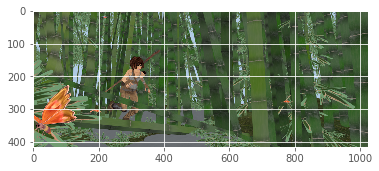

In [9]:
plt.imshow(alb_sintel_valid_b[22])

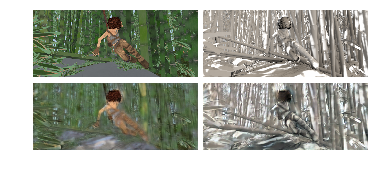

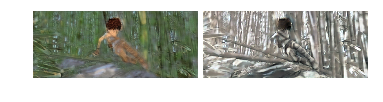

In [15]:
i = 3
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(alb_sintel_test_b[i])
axarr[0, 0].axis('off')
axarr[0, 1].imshow(shad_sintel_test_b[i])
axarr[0, 1].axis('off')
axarr[1, 0].imshow(np.clip(a=pred_alb_test[i], a_min=0, a_max=1, out=None))
axarr[1, 0].axis('off')
axarr[1, 1].imshow(np.clip(a=pred_shad_test[i], a_min=0, a_max=1, out=None))
axarr[1, 1].axis('off')
f.subplots_adjust(hspace=-0.5, wspace=0.03)

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(np.clip(a=pred_alb_test[i], a_min=0, a_max=1, out=None))
axarr[0].axis('off')
axarr[1].imshow(np.clip(a=pred_shad_test[i], a_min=0, a_max=1, out=None))
axarr[1].axis('off')
f.subplots_adjust(hspace=-0.5, wspace=0.03)

In [10]:
def get_mean_error(error_matrix, valid_mask):
    err_valid = error_matrix * valid_mask
    return err_valid.sum() / valid_mask.sum()

def get_losses(image_batch, prediction_batch, invalid_px_mask_batch):
    invalid_px_mask_batch[invalid_px_mask_batch > 0] = 1
    valid_mask = 1 - invalid_px_mask_batch
    
    diff = np.abs(image_batch - prediction_batch)
    lim = 0.2 * diff.max()
    berhu = np.where(diff>lim,
                     0.5 * ((diff ** 2 / lim) + lim),
                     diff)
    berhu_loss = get_mean_error(error_matrix=berhu, valid_mask=valid_mask)
    l1_loss = get_mean_error(error_matrix=diff, valid_mask=valid_mask)
    l2_loss = get_mean_error(error_matrix=diff**2, valid_mask=valid_mask)
    return l1_loss, l2_loss, berhu_loss

In [17]:
l1_alb_valid, l2_alb_valid, berhu_alb_valid = get_losses(image_batch=alb_sintel_valid_b,
                                                         prediction_batch=pred_alb_valid,
                                                         invalid_px_mask_batch=inv_sintel_valid_b)
l1_shad_valid, l2_shad_valid, berhu_shad_valid = get_losses(image_batch=shad_sintel_valid_b,
                                                            prediction_batch=pred_shad_valid,
                                                            invalid_px_mask_batch=inv_sintel_valid_b)
l1_alb_test, l2_alb_test, berhu_alb_test = get_losses(image_batch=alb_sintel_test_b,
                                                      prediction_batch=pred_alb_test,
                                                      invalid_px_mask_batch=inv_sintel_test_b)
l1_shad_test, l2_shad_test, berhu_shad_test = get_losses(image_batch=shad_sintel_test_b,
                                                         prediction_batch=pred_shad_test,
                                                         invalid_px_mask_batch=inv_sintel_test_b)
l1_alb_val_te, l2_alb_val_te, berhu_alb_val_te = get_losses(image_batch=np.append(alb_sintel_valid_b, alb_sintel_test_b, 0),
                                                            prediction_batch=np.append(pred_alb_valid, pred_alb_test, 0),
                                                            invalid_px_mask_batch=np.append(inv_sintel_valid_b, inv_sintel_test_b, 0))
l1_shad_val_te, l2_shad_val_te, berhu_shad_val_te = get_losses(image_batch=np.append(shad_sintel_valid_b, shad_sintel_test_b, 0),
                                                               prediction_batch=np.append(pred_shad_valid, pred_shad_test, 0),
                                                               invalid_px_mask_batch=np.append(inv_sintel_valid_b, inv_sintel_test_b, 0))

In [18]:
dict_literature = {('MSE', 'albedo'): {'Baseline: Shading Constant': 0.0531,
                                       'Baseline: Albedo Constant': 0.0369,
                                       'Retinex \cite{grosse2009}': 0.0606,
                                       'Lee et al. \cite{lee2012}': 0.0463,
                                       'Barron et al. \cite{barron2015}': 0.0420,
                                       'Chen and Koltun \cite{chen2013}': 0.0307,
                                       'Narihira et al. \cite{narihira2015}': 0.0201},
                   ('MSE', 'shading'): {'Baseline: Shading Constant': 0.0488,
                                        'Baseline: Albedo Constant': 0.0378,
                                        'Retinex \cite{grosse2009}': 0.0727,
                                        'Lee et al. \cite{lee2012}': 0.0507,
                                        'Barron et al. \cite{barron2015}': 0.0436,
                                        'Chen and Koltun \cite{chen2013}': 0.0277,
                                        'Narihira et al. \cite{narihira2015}': 0.0224},
                  }
df_literature = pd.DataFrame.from_dict(dict_literature, orient='Index')
df_literature = df_literature[['Baseline: Shading Constant', 'Baseline: Albedo Constant', 
                               'Retinex \cite{grosse2009}', 'Lee et al. \cite{lee2012}', 
                               'Barron et al. \cite{barron2015}',
                               'Chen and Koltun \cite{chen2013}',
                               'Narihira et al. \cite{narihira2015}']].transpose()
means = df_literature.mean(axis=1)
sums = df_literature.sum(axis=1)
df_literature[('MSE', 'avg')] = means
df_literature[('MSE', 'sum')] = sums

In [19]:
df_literature.loc['ours']

MSE                         
                                     albedo shading      avg     sum
Baseline: Shading Constant           0.0531  0.0488  0.05095  0.1019
Baseline: Albedo Constant            0.0369  0.0378  0.03735  0.0747
Retinex \cite{grosse2009}            0.0606  0.0727  0.06665  0.1333
Lee et al. \cite{lee2012}            0.0463  0.0507  0.04850  0.0970
Barron et al. \cite{barron2015}      0.0420  0.0436  0.04280  0.0856
Chen and Koltun \cite{chen2013}      0.0307  0.0277  0.02920  0.0584
Narihira et al. \cite{narihira2015}  0.0201  0.0224  0.02125  0.0425

In [45]:
inv_sintel_valid_b[inv_sintel_valid_b > 0] = 1
valid_mask = 1 - inv_sintel_valid_b

In [83]:
diff = np.abs(alb_sintel_valid_b - pred_alb)
lim = 0.2 * diff.max()
berhu = np.where(diff>lim,
                 0.5 * ((diff ** 2 / lim) + lim),
                 diff)

In [63]:
sqrt_err = diff**2

sqrt_err_valid = sqrt_err * valid_mask
mean_sqrt_err_valid = sqrt_err_valid.sum() / valid_mask.sum()

In [89]:
get_mean_error(error_matrix=berhu, valid_mask=valid_mask)

0.17720598692489531

In [67]:
get_mean_error(error_matrix=diff, valid_mask=valid_mask)

0.15909726750804509

In [66]:
get_mean_error(error_matrix=diff**2, valid_mask=valid_mask)

0.038886561100958637

In [ ]:
tf.square(tf.reduce_sum(diff_valid) / n_valid)
get_mean_error(error_matrix=diff**2, valid_mask=valid_mask)

In [64]:
mean_sqrt_err_valid

0.038886561100958637

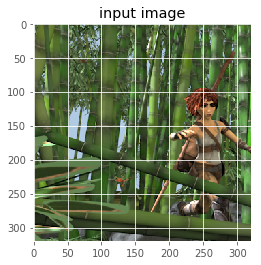

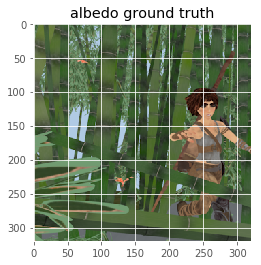

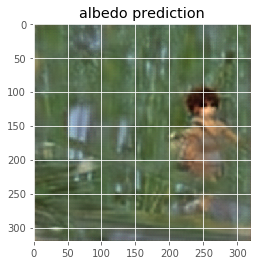

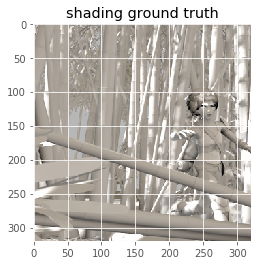

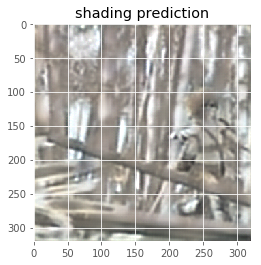

In [82]:
#print(f'path to (raw) image: {path_te}')
i = 0  # index over batches (here batch==1 single image)
plt_help.plot_images(images=[img_sintel_valid_b[i], 
                             alb_sintel_valid_b[i], 
                             np.clip(a=pred_alb[i], a_min=0, a_max=1, out=None), 
                             shad_sintel_valid_b[i], 
                             np.clip(a=pred_shad[i], a_min=0, a_max=1, out=None)],
                     titles=['input image', 
                             'albedo ground truth', 
                             'albedo prediction', 
                             'shading ground truth', 
                             'shading prediction'])

In [11]:
def losses(img_sintel_b, alb_sintel_b, shad_sintel_b, inv_sintel_b, pred_alb, pred_shad):
    tf.reset_default_graph()
    batch_size = 16

    ph_input_image = tf.placeholder(dtype=tf.float32, name='input_image')
    ph_label_albedo = tf.placeholder(dtype=tf.float32, name='label_albedo')
    ph_label_shading = tf.placeholder(dtype=tf.float32, name='label_shading')
    ph_prediction_albedo = tf.placeholder(dtype=tf.float32, name='prediction_albedo')
    ph_prediction_shading = tf.placeholder(dtype=tf.float32, name='prediction_shading')
    ph_valid_mask = tf.placeholder(dtype=tf.float32, name='valid_mask')

    d = {'label_albedo': ph_label_albedo,
         'label_shading': ph_label_shading,
         'prediction_albedo': ph_prediction_albedo, 
         'prediction_shading': ph_prediction_shading,
         'valid_mask': ph_valid_mask}

    loss_dict = {'berhu': chlp.sintel_loss_fct(**d, **{'loss_type': 'berhu', 
                                                       'lambda_': None}),
                 'l1': chlp.sintel_loss_fct(**d, **{'loss_type': 'l1',
                                                    'lambda_': None}),
                 'l2': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2', 
                                                    'lambda_': 0}),
                 'l2_inv': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2',
                                                        'lambda_': 1}),
                 'l2_avg': chlp.sintel_loss_fct(**d, **{'loss_type': 'l2',
                                                        'lambda_': 0.5}),
                 'berhu_general': chlp.berhu_loss(label=ph_input_image,
                                                  prediction=ph_prediction_albedo*ph_prediction_shading,
                                                  valid_mask=ph_valid_mask),
                 'l1_general': chlp.l1_loss(label=ph_input_image,
                                            prediction=ph_prediction_albedo*ph_prediction_shading,
                                            valid_mask=ph_valid_mask),
                 'l2_general': chlp.l2_loss(label=ph_input_image,
                                            prediction=ph_prediction_albedo*ph_prediction_shading,
                                            lambda_=0,
                                            valid_mask=ph_valid_mask)
                }

    # define the sintel dataset loss dict:
    valid_dict = {key: tf.placeholder(dtype=tf.float32, name=key) for \
                  key in loss_dict.keys()}


    # Validation:
    config = tf.ConfigProto(device_count = {'GPU': 1},
                            intra_op_parallelism_threads=3)
    with tf.Session(config=config) as sess: 
        valid_mask = chlp.get_valid_pixels(image=img_sintel_b, 
                                           invalid_mask=inv_sintel_b)
        valid_mask = sess.run(valid_mask)

        # use the complete test data set to calculate the error/accuracy on the
        # test set above:
        # loop through one data set epoch:
        # initialize dictionary which contains all losses:
        valid_loss_dict = dict.fromkeys(loss_dict, 0)
        valid_steps_per_epoch = int(img_sintel_b.shape[0] / batch_size)
        print(valid_steps_per_epoch)
        batch_limits = list(range(0, img_sintel_b.shape[0], batch_size)) + [img_sintel_b.shape[0] - 1]
        print(batch_limits)
        for i in range(len(batch_limits) - 1):
            print(i)
            # calculate the mean loss of this validation batch and 
            # sum it with the previous mean batch losses:
            fd_val = {ph_input_image: img_sintel_b[batch_limits[i]:batch_limits[i+1]],
                      ph_label_albedo: alb_sintel_b[batch_limits[i]:batch_limits[i+1]],
                      ph_label_shading: shad_sintel_b[batch_limits[i]:batch_limits[i+1]],
                      ph_prediction_albedo: pred_alb[batch_limits[i]:batch_limits[i+1]], 
                      ph_prediction_shading: pred_shad[batch_limits[i]:batch_limits[i+1]],
                      ph_valid_mask: valid_mask[batch_limits[i]:batch_limits[i+1]]}

            for key, val in loss_dict.items():
                # divide each loss loss by the iteration steps 
                # (steps_per_epoch) to get the mean val loss:
                mean_val = val / valid_steps_per_epoch
                print(mean_val)
                val_eval, mean_val_eval = sess.run([val, mean_val], feed_dict=fd_val)
                print(val_eval)
                print(mean_val_eval)
                valid_loss_dict[key] += mean_val_eval 
    return valid_loss_dict

In [12]:
losses(img_sintel_b=img_sintel_valid_b,
       alb_sintel_b=alb_sintel_valid_b, 
       shad_sintel_b=shad_sintel_valid_b,
       inv_sintel_b=inv_sintel_valid_b,
       pred_alb=pred_alb,
       pred_shad=pred_shad)

6
[0, 16, 32, 48, 64, 80, 96, 101]
0
Tensor("truediv_23:0", dtype=float32)
0.0870691
0.0145115
Tensor("truediv_24:0", dtype=float32)
0.0436133
0.00726888
Tensor("truediv_25:0", dtype=float32)
0.0645375
0.0107563
Tensor("truediv_26:0", dtype=float32)
0.316166
0.0526943
Tensor("truediv_27:0", dtype=float32)
0.0123528
0.00205879
Tensor("truediv_28:0", dtype=float32)
0.022689
0.00378151
Tensor("truediv_29:0", dtype=float32)
0.282875
0.0471458
Tensor("truediv_30:0", dtype=float32)
0.08576
0.0142933
1
Tensor("truediv_31:0", dtype=float32)
0.0795626
0.0132604
Tensor("truediv_32:0", dtype=float32)
0.0337323
0.00562204
Tensor("truediv_33:0", dtype=float32)
0.0482849
0.00804749
Tensor("truediv_34:0", dtype=float32)
0.258293
0.0430488
Tensor("truediv_35:0", dtype=float32)
0.0110857
0.00184762
Tensor("truediv_36:0", dtype=float32)
0.0191796
0.0031966
Tensor("truediv_37:0", dtype=float32)
0.236969
0.0394948
Tensor("truediv_38:0", dtype=float32)
0.0776213
0.0129369
2
Tensor("truediv_39:0", dtype=flo

{'berhu': 0.34317202493548393,
 'berhu_general': 0.097445623949170113,
 'l1': 0.3082532025873661,
 'l1_general': 0.095155403949320316,
 'l2': 0.068121596239507198,
 'l2_avg': 0.046605994924902916,
 'l2_general': 0.013513341546058655,
 'l2_inv': 0.025090394075959921}

In [33]:
valid_loss_dict

{'berhu': 0.29015316814184189,
 'berhu_general': 0.086192527785897255,
 'l1': 0.25555310398340225,
 'l1_general': 0.080988069996237755,
 'l2': 0.055316713638603687,
 'l2_avg': 0.036787205375730991,
 'l2_general': 0.011454315041191876,
 'l2_inv': 0.018257698509842157}

## Predictions for IIW dataset
### Load IIW dataset:

/home/udo/image_decomposition/input_queues.py:794: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_point_crop['x'] = (df_point_crop['x'] * img.shape[1] - x_start) / output_shape[1]
/home/udo/image_decomposition/input_queues.py:795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_point_crop['y'] = (df_point_crop['y'] * img.shape[0] - y_start) / output_shape[0]
/home/udo/image_decomposition/input_queues.py:842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

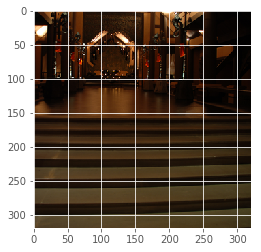

In [13]:
file_iiw = 'data_iiw_test.csv'
df_test_iiw = pd.read_csv(filepath_or_buffer=data_dir + file_iiw, 
                          sep=',', header=None,
                          names=['img', 'json_label'])
# complete image paths:
df_test_iiw = data_dir + df_test_iiw
# # get one test image path (and its ground truth labels):
# df_image_paths_iiw = df_test_iiw.loc[[1], ['img', 'json_label']]

# import one image:
df_iiw, images_iiw, images_original_iiw, js_labels_iiw, js_labels_original_iiw = iq.next_batch_iiw(deq=df_test_iiw.loc[:100,:],
                                                                                                   output_shape=[320, 320, 3],
                                                                                                   norm=True)
plt.imshow(images_iiw[0])

### Perform predictions on iiw dataset:

In [16]:
# slim_resnet_v1_50_deconv_decoder/...:
nodes_name_dict = {'input': 'input:0',
                   'output_albedo': 'decoder/deconv7_albedo/BiasAdd:0',
                   'output_shading': 'decoder/deconv7_shading/BiasAdd:0'}
# .../norm_l1:
params = {'path_inference_graph': 'models/slim/graphs/resnet_v1_50_narihira2015_reduced/tfmodel_inference.meta',
          'checkpoint_path': 'logs/iiw/slim_resnet_v1_50_narihira2015_reduced/norm_l1_01mwhdl/2/tfmodel-9100',
          'nodes_name_dict': nodes_name_dict,
          'plot_inference_graph': False}

In [17]:
pred_alb, pred_shad = predict(image=images_iiw, **params)

INFO: Was able to catch is_training node.
Tensor("is_training:0", dtype=bool)
INFO:tensorflow:Restoring parameters from logs/iiw/slim_resnet_v1_50_narihira2015_reduced/norm_l1_01mwhdl/2/tfmodel-9100


In [ ]:
#print(f'path to (raw) image: {path_te}')
i = 0  # index over batches (here batch==1 single image)
plt_help.plot_images(images=[images_iiw[i], 
                             alb_sintel_test_b[i], 
                             np.clip(a=pred_alb[i], a_min=0, a_max=1, out=None), 
                             shad_sintel_test_b[i], 
                             np.clip(a=pred_shad[i], a_min=0, a_max=1, out=None)],
                     titles=['input image', 
                             'albedo ground truth', 
                             'albedo prediction', 
                             'shading ground truth', 
                             'shading prediction'])

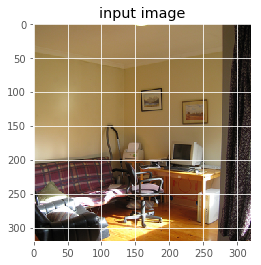

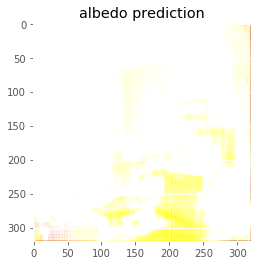

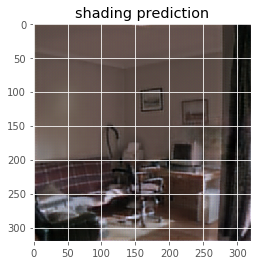

In [26]:
#print(f'path to (raw) image: {path_te}')
i = 4  # index over batches (here batch==1 single image)
plt_help.plot_images(images=[images_iiw[i], 
                             np.clip(a=pred_alb[i], a_min=0, a_max=1, out=None), 
                             np.clip(a=pred_shad[i], a_min=0, a_max=1, out=None)],
                     titles=['input image', 
                             'albedo prediction', 
                             'shading prediction'])

In [13]:
lambda_loss = 1.0
ph_input_image = tf.placeholder(dtype=tf.float32, name='input_image')
ph_prediction_albedo = tf.placeholder(dtype=tf.float32, name='prediction_albedo')
ph_prediction_shading = tf.placeholder(dtype=tf.float32, name='prediction_shading')
point1 = tf.placeholder(dtype=tf.int32, name='point1')
point2 = tf.placeholder(dtype=tf.int32, name='point2')
# get the human darker labels:
human_labels = tf.placeholder(dtype=tf.int32, name='human_labels')
# list of weights/darker scores:
darker_weights = tf.placeholder(dtype=tf.float32, name='darker_weights')

losses_iiw = chlp.iiw_loss_fct(input_image=ph_input_image,
                               prediction_albedo=ph_prediction_albedo,
                               prediction_shading=ph_prediction_shading,
                               albedo_comp_point1=point1,
                               albedo_comp_point2=point2,
                               albedo_comp_human_labels=human_labels,
                               albedo_comp_weights=darker_weights,
                               albedo_comp_delta=0.1,
                               lambda_=lambda_loss)

loss_dict = {'l1_mhdl': losses_iiw[0],
             'l1_mwhdl': losses_iiw[1],
             'l2_mhdl': losses_iiw[2],
             'l2_mwhdl': losses_iiw[3],
             'l1': losses_iiw[4],
             'l2': losses_iiw[5],
             'mhdl': losses_iiw[6],
             'mwhdl': losses_iiw[7],
             'berhu_general': chlp.berhu_loss(label=ph_input_image,
                                              prediction=ph_prediction_albedo*ph_prediction_shading,
                                              valid_mask=None),
             'l1_general': chlp.l1_loss(label=ph_input_image,
                                        prediction=ph_prediction_albedo*ph_prediction_shading,
                                        valid_mask=None),
             'l2_general': chlp.l2_loss(label=ph_input_image,
                                        prediction=ph_prediction_albedo*ph_prediction_shading,
                                        lambda_=0,
                                        valid_mask=None)
            }

In [14]:
config = tf.ConfigProto(device_count = {'GPU': 1},
                        intra_op_parallelism_threads=3)
with tf.Session(config=config) as sess: 
    fd = {ph_input_image: images_iiw,
          ph_prediction_albedo: pred_alb,
          ph_prediction_shading: pred_shad,
          point1: df_iiw[['batch_nr', 'y1', 'x1']].values,
          point2: df_iiw[['batch_nr', 'y2', 'x2']].values,
          human_labels: df_iiw['darker'].values,
          darker_weights: df_iiw['darker_score'].values
         }
    # run optimization step:
    losses_iiw_results = sess.run(loss_dict, feed_dict=fd)

In [15]:
losses_iiw_results

{'l1': 328858.81,
 'l1_mhdl': 330047.69,
 'l1_mwhdl': 329701.25,
 'l2': 1.9749451e+13,
 'l2_mhdl': 1.9749451e+13,
 'l2_mwhdl': 1.9749451e+13,
 'mhdl': 1188.8892,
 'mwhdl': 842.44788}

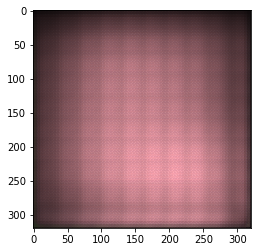

In [15]:
plt.imshow((pred_alb[0] - pred_alb[0].min())/ (pred_alb[0].max()-pred_alb[0].min()))

In [17]:
# !tensorboard --logdir ./logs/camp/2

## resizing an image

In [7]:
import scipy as sp

In [10]:
images[0].reshape(params['image_shape']).shape

(416, 416, 3)

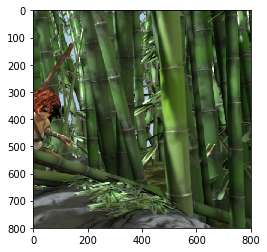

In [16]:
plt.imshow(sp.misc.imresize(arr=images[0].reshape(params['image_shape']),
                 size=(800, 800, 3), interp='bilinear', mode=None))

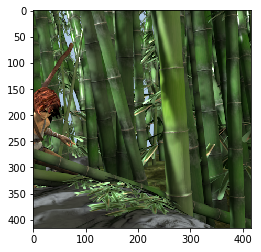

In [17]:
plt.imshow(images[0].reshape(params['image_shape']))